In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
# 1. Generate sine wave
time = np.arange(0, 200, 0.1)
series = np.sin(time)

In [4]:
# 2. Create sliding window dataset
def create_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 50
X, y = create_dataset(series, window_size)

In [5]:
# 3. Train/test split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [6]:
# 4. Build simple DNN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(window_size,)),
    Dense(32, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer='adam', loss='mse')
history=model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


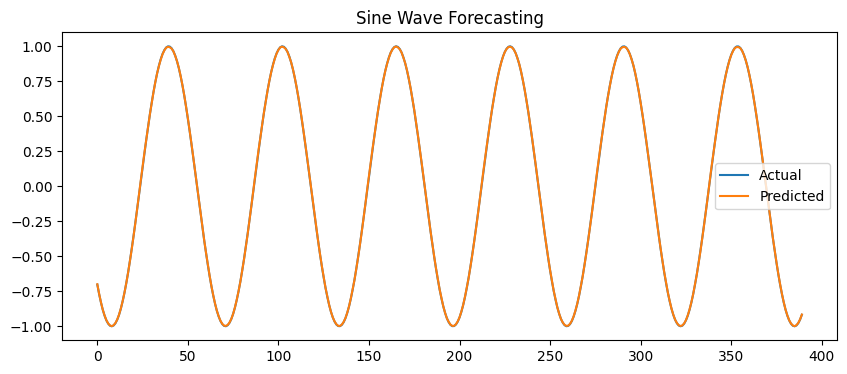

In [9]:
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, label='Actual')
plt.plot(range(len(y_pred)), y_pred, label='Predicted')
plt.legend()
plt.title('Sine Wave Forecasting')
plt.show()



In [ ]:
# 5. Predict
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
# 6. Simple accuracy (within 0.05 tolerance)
def accuracy(y_true, y_pred, tol=0.05):
    correct = np.abs(y_true - y_pred.squeeze()) < tol
    return np.mean(correct)

train_acc = accuracy(y_train, train_pred)
test_acc = accuracy(y_test, test_pred)

print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy:  {test_acc * 100:.2f}%")

Train Accuracy: 100.00%
Test Accuracy:  100.00%


In [ ]:
# 6. Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(y_true, y_pred, label=''):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{label} MSE: {mse:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

evaluate(y_train, train_pred, "Train")
evaluate(y_test, test_pred, "Test")

Train MSE: 0.0001 | MAE: 0.0059 | RMSE: 0.0074
Test MSE: 0.0001 | MAE: 0.0058 | RMSE: 0.0073


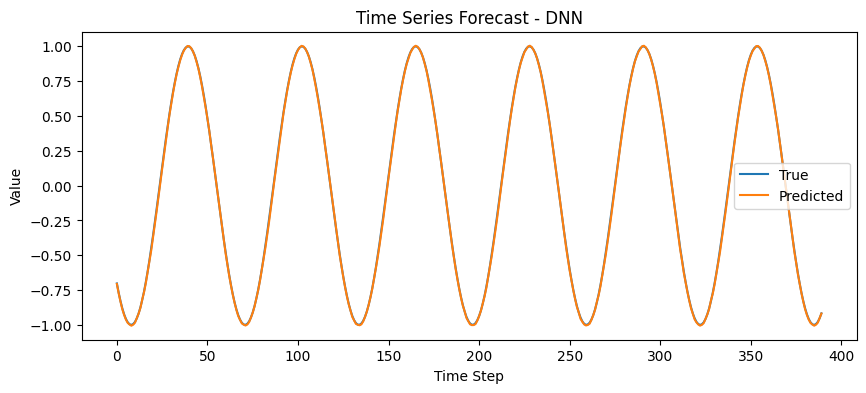

In [ ]:
# 7. Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test, label='True')
plt.plot(test_pred.squeeze(), label='Predicted')
plt.title("Time Series Forecast - DNN")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
# Custom pseudo-accuracy: how many predictions are within tolerance
import tensorflow as tf
def pseudo_accuracy(y_true, y_pred, tol=0.05):
    return np.mean(np.abs(y_true - y_pred.squeeze()) < tol)

# Custom callback to record accuracy
class AccuracyHistory(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.X_train, verbose=0)
        y_val_pred = self.model.predict(self.X_val, verbose=0)
        acc_train = pseudo_accuracy(self.y_train, y_train_pred)
        acc_val = pseudo_accuracy(self.y_val, y_val_pred)
        self.train_acc.append(acc_train)
        self.val_acc.append(acc_val)

In [ ]:
# Create the callback object
history_acc = AccuracyHistory(X_train, y_train, X_test, y_test)

# Fit model
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0, callbacks=[history_acc])

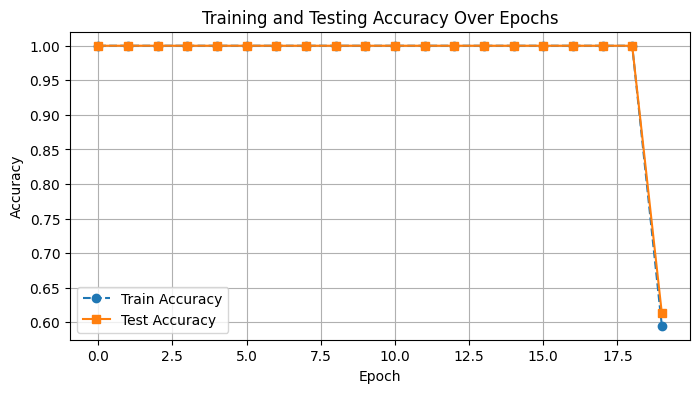

In [ ]:
# Plot accuracy over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history_acc.train_acc, 'o--', label='Train Accuracy')
plt.plot(history_acc.val_acc, 's-', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

